**FineTuning BERT(Language Model) for Multi-Class Classification using clothing Brand Reviews**

In [ ]:
!pip install transformers

In [ ]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

dataset locally downloaded from kaggle

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/brand_reviews.csv')
df

,comments,brand_name,sentiment
0,Not yet tried but as listened they have good q...,AlkaramStudios,Positive
1,Cooperative Staff,AlkaramStudios,Positive
2,Nice one location and available parking staff ...,AlkaramStudios,Positive
3,Nice Place for shopping.,AlkaramStudios,Positive
4,Nice branch of Al Karam,AlkaramStudios,Positive
...,...,...,...
1411,wow,Uniworth,Positive
1412,Good,Uniworth,Positive
1413,Awesome,Uniworth,Positive
1414,A good shop for shirt and ties,Uniworth,Positive


labelling of different comments o differnent brands

In [ ]:
labels = df['sentiment'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['Positive', 'Neutral', 'Negative']

In [ ]:
for key, value in enumerate(labels):
    print(value)


Positive
Neutral
Negative


mapping of lables

In [ ]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [ ]:
label2id

{'Positive': 0, 'Neutral': 1, 'Negative': 2}

In [ ]:
id2label

{0: 'Positive', 1: 'Neutral', 2: 'Negative'}

In [ ]:
df.head()

,comments,brand_name,sentiment
0,Not yet tried but as listened they have good q...,AlkaramStudios,Positive
1,Cooperative Staff,AlkaramStudios,Positive
2,Nice one location and available parking staff ...,AlkaramStudios,Positive
3,Nice Place for shopping.,AlkaramStudios,Positive
4,Nice branch of Al Karam,AlkaramStudios,Positive


In [ ]:
df["labels"]=df.sentiment.map(lambda x: label2id[x.strip()])

In [ ]:
df.head()

,comments,brand_name,sentiment,labels
0,Not yet tried but as listened they have good q...,AlkaramStudios,Positive,0
1,Cooperative Staff,AlkaramStudios,Positive,0
2,Nice one location and available parking staff ...,AlkaramStudios,Positive,0
3,Nice Place for shopping.,AlkaramStudios,Positive,0
4,Nice branch of Al Karam,AlkaramStudios,Positive,0


<Axes: ylabel='sentiment'>

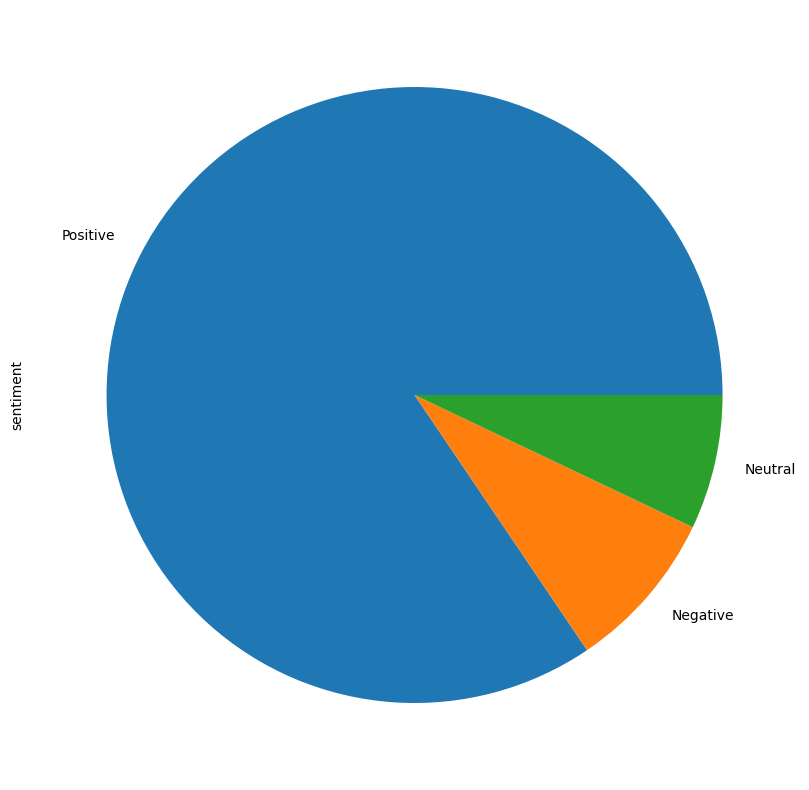

In [ ]:
df.sentiment.value_counts().plot(kind='pie', figsize=(10,10))

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

import re
from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
swords = stopwords.words('english')

In [ ]:
import nltk
nltk.download('omw-1.4')

def preprocess(sentence):
    tweet = re.sub(r"@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', sentence)

    # remove all single characters
    tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)

    # Substituting multiple spaces with single space
    tweet = re.sub(r'\s+', ' ', tweet, flags=re.I)

    # Converting to Lowercase
    tweet = tweet.lower()

    # Lemmatization
    tweet = tweet.split(' ')
    tweet = [word for word in tweet if word not in swords]
    tweet = [stemmer.lemmatize(word) for word in tweet]
    tweet = ' '.join(tweet)
    return tweet

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
df['comments'] = df['comments'].apply(preprocess)

FineTune BERT Model for sequence classification

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=512)

In [ ]:

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Splitting dataframe

In [ ]:
SIZE= df.shape[0]

train_comments= list(df.comments[:SIZE//2])

val_comments=   list(df.comments[SIZE//2:(3*SIZE)//4 ])

test_comments=  list(df.comments[(3*SIZE)//4:])

train_labels= list(df.labels[:SIZE//2])

val_labels=   list(df.labels[SIZE//2:(3*SIZE)//4])

test_labels=  list(df.labels[(3*SIZE)//4:])

In [ ]:
len(train_comments)

708

In [ ]:
len(train_comments), len(val_comments), len(test_comments)

(708, 354, 354)

In [ ]:
train_encodings = tokenizer(train_comments, truncation=True, padding=True)
val_encodings  = tokenizer(val_comments, truncation=True, padding=True)
test_encodings = tokenizer(test_comments, truncation=True, padding=True)

In [ ]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)


In [ ]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

Training with Trainer Class

In [ ]:
from transformers import TrainingArguments, Trainer

compute_metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.

    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of
              that observation belonging to a certain class.

    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [ ]:
!pip install transformers[torch]
!pip install accelerate>=0.20.1

In [ ]:
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive',
    do_train=True,
    do_eval=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    fp16=True,
    load_best_model_at_end=True,
    fp16_full_eval=False
)


In [ ]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,0.859500,0.414350,0.884181,0.312844,0.294727,0.333333
100,0.425000,0.273711,0.887006,0.643959,0.604283,0.706594


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=135, training_loss=0.5450070275200738, metrics={'train_runtime': 24.6569, 'train_samples_per_second': 86.142, 'train_steps_per_second': 5.475, 'total_flos': 72039631544496.0, 'train_loss': 0.5450070275200738, 'epoch': 3.0})

In [ ]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.162504,0.949153,0.880682,0.896684,0.877265
val,0.301710,0.870056,0.608797,0.575916,0.686468
test,0.338757,0.855932,0.557416,0.514665,0.671538


In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

In [ ]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cpu")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label
    # Since pred_label_idx is a tensor containing a single value (the predicted class index),
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [ ]:
# Test with a an example text
text = "Good but prices are a little bit high."
predict(text)

(tensor([[0.1866, 0.7682, 0.0452]], grad_fn=<SoftmaxBackward0>),
 tensor(1),
 'Neutral')

Save model for inference

In [ ]:
model_path = "text-classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('text-classification-model/tokenizer_config.json',
 'text-classification-model/special_tokens_map.json',
 'text-classification-model/vocab.txt',
 'text-classification-model/added_tokens.json',
 'text-classification-model/tokenizer.json')

Re-Load saved model for inference

In [ ]:
model_path = "text-classification-model"
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [ ]:
nlp('Good but prices are a little bit high.')

[{'label': 'Neutral', 'score': 0.7681713104248047}]

In [ ]:
nlp('Exellent shoping place for ready made garments')

[{'label': 'Positive', 'score': 0.9846827387809753}]

In [ ]:
nlp('Very High prices. Just a shirt for PKR 3600.')

[{'label': 'Negative', 'score': 0.8174362182617188}]